# Feature-Set Experiments: Best General Score per Age Group

This notebook loads `feature_set_k_experiments.csv` and reports, for each age group, the experiment row with the highest `general_score`.

In [38]:
from pathlib import Path
import pandas as pd
import os
os.environ["OMP_NUM_THREADS"] = "1"
csv_path = Path('../results/feature_set_experiments/feature_set_k_experiments.csv')
df = pd.read_csv(csv_path)
print(f'Loaded: {csv_path}')
print(f'Rows: {len(df)}')
df.head()

Loaded: ..\results\feature_set_experiments\feature_set_k_experiments.csv
Rows: 72


,age_group,feature_set,feature_cols,k,status,n_units,n_runs,bic_mean,bic_std,silhouette_mean,silhouette_std,stability_ari,score_bic,score_silhouette,score_stability_ari,general_score
0,P15_16,few_features,fr_hz+spk_duration_ms+refractory_ms_edge,2,ok,112,5,899.155446,0.000000e+00,0.306584,0.0,1.0,0.909091,1.000000,0.590909,0.833333
1,P15_16,few_features,fr_hz+spk_duration_ms+refractory_ms_edge,1,ok,112,5,982.229500,1.136868e-13,NaN,NaN,1.0,0.818182,NaN,0.590909,0.704545
2,P15_16,some_features,fr_hz+cv2+acg_peak_latency_ms+spk_duration_ms+...,2,ok,112,5,1394.796525,1.297557e-04,0.217512,0.0,1.0,0.681818,0.642857,0.590909,0.638528
3,P15_16,valero_features,cv2+acg_peak_latency_ms+spk_duration_ms+spk_as...,2,ok,112,5,1394.796525,1.297557e-04,0.217512,0.0,1.0,0.681818,0.642857,0.590909,0.638528
4,P15_16,all_features,fr_hz+burst_index+cv2+spk_duration_ms+spk_peak...,2,ok,112,5,2034.351680,2.282754e-02,0.251490,0.0,1.0,0.090909,0.857143,0.590909,0.512987


In [47]:
# Keep valid experiment rows and pick the best general_score per age_group
d = df[df['status'] == 'ok'].copy()
best_idx = d.groupby('age_group')['general_score'].idxmax()
best_per_group = d.loc[best_idx].sort_values('age_group').reset_index(drop=True)

cols = [
    'age_group', 'feature_set', 'k', 'general_score',
    'bic_mean', 'silhouette_mean', 'stability_ari',
    'score_bic', 'score_silhouette', 'score_stability_ari'
]
best_per_group[cols]

,age_group,feature_set,k,general_score,bic_mean,silhouette_mean,stability_ari,score_bic,score_silhouette,score_stability_ari
0,P15_16,few_features,2,0.833333,899.155446,0.306584,1.000000,0.909091,1.0,0.590909
1,P17_18,few_features,2,0.787879,1872.705751,0.331301,0.986191,1.000000,1.0,0.363636
2,P19_20,few_features,1,0.772727,1871.916705,NaN,1.000000,0.818182,NaN,0.727273
3,P21_22,few_features,2,0.863636,2619.758979,0.361907,1.000000,0.909091,1.0,0.681818
4,P23_24,few_features,2,0.924242,1451.261542,0.360182,1.000000,1.000000,1.0,0.772727
5,P25,few_features,1,0.772727,882.152383,NaN,1.000000,0.818182,NaN,0.727273


In [40]:
# Optional: save the summary table
out_path = Path('../results/feature_set_experiments/best_general_score_by_age.csv')
best_per_group.to_csv(out_path, index=False)
print(f'Wrote: {out_path}')

Wrote: ..\results\feature_set_experiments\best_general_score_by_age.csv


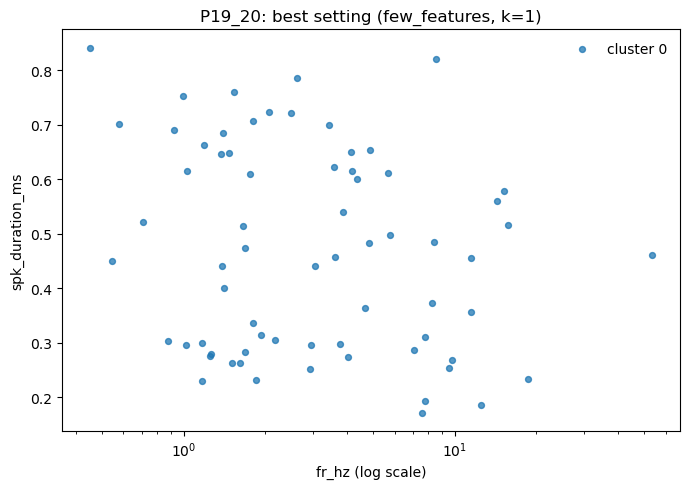

In [4]:
# Plot neurons by GMM cluster on fr_hz vs spk_duration_ms
from sklearn.mixture import GaussianMixture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

age_group = "P19_20"  # change as needed

# assumes best_per_group exists from previous cells
row = best_per_group[best_per_group["age_group"] == age_group].iloc[0]
feature_cols = row["feature_cols"].split("+")
k = int(row["k"])

df_age = pd.read_parquet(f"../results/{age_group}/{age_group}_clean_units.parquet").copy()
if "fr_hz" not in df_age.columns or "spk_duration_ms" not in df_age.columns:
    raise ValueError("fr_hz and spk_duration_ms must be present in clean_units parquet")

# Rebuild matrix with same preprocessing used in experiments
df_m = df_age.copy()
used = []
for c in feature_cols:
    if c == "fr_hz":
        df_m["log10_fr_hz"] = np.log10(df_m["fr_hz"].clip(lower=1e-6))
        used.append("log10_fr_hz")
    elif c in df_m.columns:
        used.append(c)

X = df_m[used].to_numpy(dtype=float)
mask = np.isfinite(X).all(axis=1)
df_plot = df_m.loc[mask].copy()
X = X[mask]

# standardize
mu = X.mean(axis=0)
sd = X.std(axis=0, ddof=0)
sd[sd == 0] = 1.0
Xz = (X - mu) / sd

# fit with same model family used in experiments
gmm = GaussianMixture(n_components=k, random_state=0, n_init=10, covariance_type="full")
labels = gmm.fit_predict(Xz)
df_plot["gmm_cluster"] = labels

fig, ax = plt.subplots(figsize=(7, 5))
for cl in sorted(df_plot["gmm_cluster"].unique()):
    s = df_plot[df_plot["gmm_cluster"] == cl]
    ax.scatter(s["fr_hz"], s["spk_duration_ms"], s=18, alpha=0.75, label=f"cluster {cl}")

ax.set_xscale("log")
ax.set_xlabel("fr_hz (log scale)")
ax.set_ylabel("spk_duration_ms")
ax.set_title(f"{age_group}: best setting ({row['feature_set']}, k={k})")
ax.legend(frameon=False)
plt.tight_layout()
plt.show()


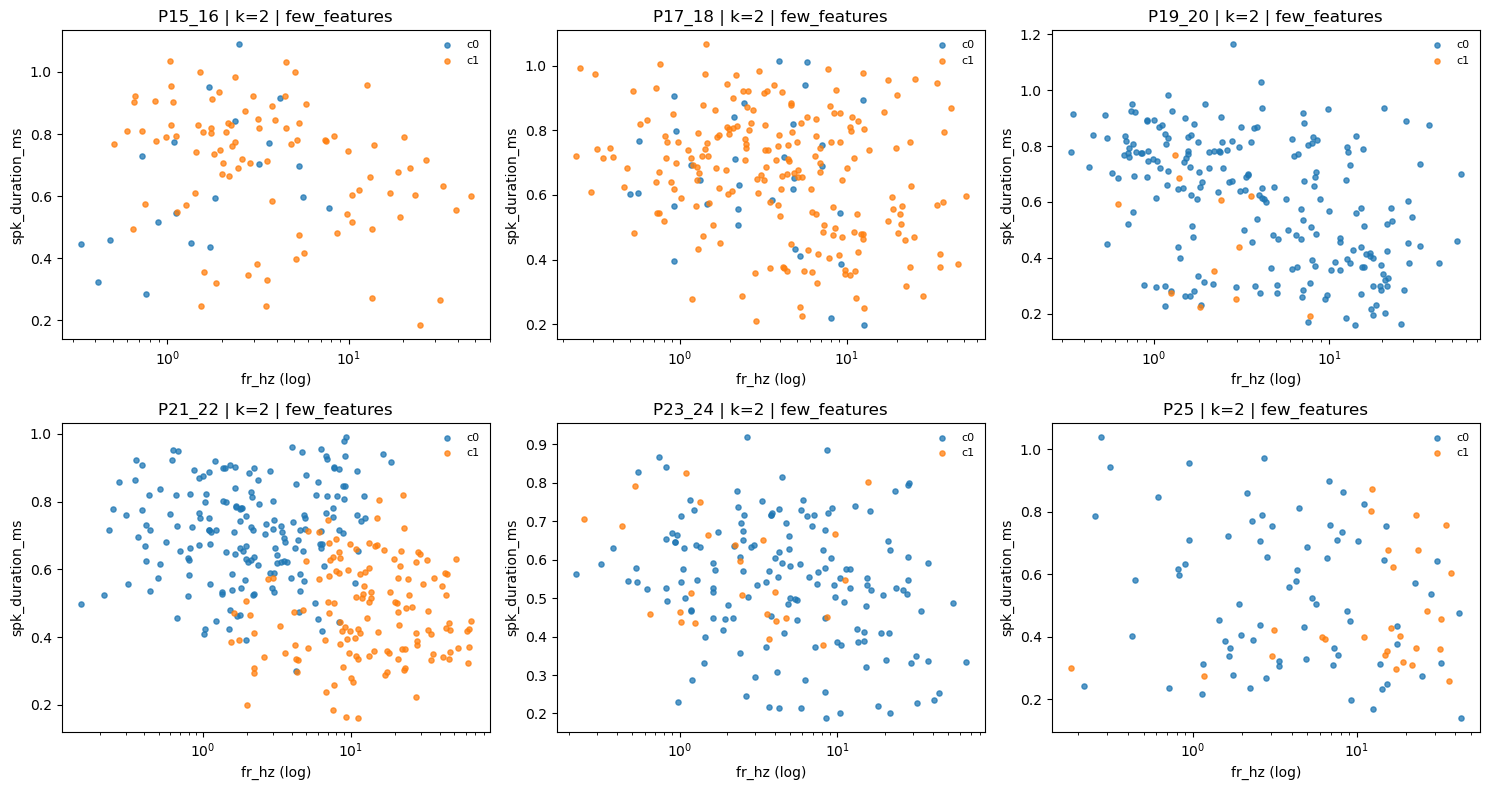

In [48]:
# For each age group, plot fr_hz vs spk_duration_ms with clusters from k=2
import os
os.environ["OMP_NUM_THREADS"] = "1"
from sklearn.mixture import GaussianMixture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

results_csv = "../results/feature_set_experiments/feature_set_k_experiments.csv"
exp = pd.read_csv(results_csv)

# keep only valid k=2 rows
k2 = exp[(exp["status"] == "ok") & (exp["k"] == 2)].copy()

# choose best k=2 config per age_group by general_score
best_k2 = (
    k2.sort_values(["age_group", "general_score"], ascending=[True, False])
      .groupby("age_group", as_index=False)
      .first()
)

age_groups = best_k2["age_group"].tolist()
n = len(age_groups)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), squeeze=False)
axes = axes.ravel()

for i, row in best_k2.iterrows():
    ax = axes[i]
    age_group = row["age_group"]
    feature_cols = row["feature_cols"].split("+")
    k = int(row["k"])  # should be 2

    df = pd.read_parquet(f"../results/{age_group}/{age_group}_clean_units.parquet").copy()

    # rebuild feature matrix with same preprocessing
    used = []
    for c in feature_cols:
        if c == "fr_hz":
            df["log10_fr_hz"] = np.log10(df["fr_hz"].clip(lower=1e-6))
            used.append("log10_fr_hz")
        elif c in df.columns:
            used.append(c)

    X = df[used].to_numpy(dtype=float)
    mask = np.isfinite(X).all(axis=1) & np.isfinite(df["fr_hz"].to_numpy()) & np.isfinite(df["spk_duration_ms"].to_numpy())
    d = df.loc[mask].copy()
    X = X[mask]

    # standardize
    mu = X.mean(axis=0)
    sd = X.std(axis=0, ddof=0)
    sd[sd == 0] = 1.0
    Xz = (X - mu) / sd

    gmm = GaussianMixture(n_components=k, random_state=0, n_init=10, covariance_type="full")
    labels = gmm.fit_predict(Xz)
    d["cluster"] = labels

    for cl in sorted(d["cluster"].unique()):
        s = d[d["cluster"] == cl]
        ax.scatter(s["fr_hz"], s["spk_duration_ms"], s=14, alpha=0.75, label=f"c{cl}")

    ax.set_xscale("log")
    ax.set_xlabel("fr_hz (log)")
    ax.set_ylabel("spk_duration_ms")
    ax.set_title(f"{age_group} | k=2 | {row['feature_set']}")
    ax.legend(frameon=False, fontsize=8)

# hide unused axes
for j in range(len(best_k2), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


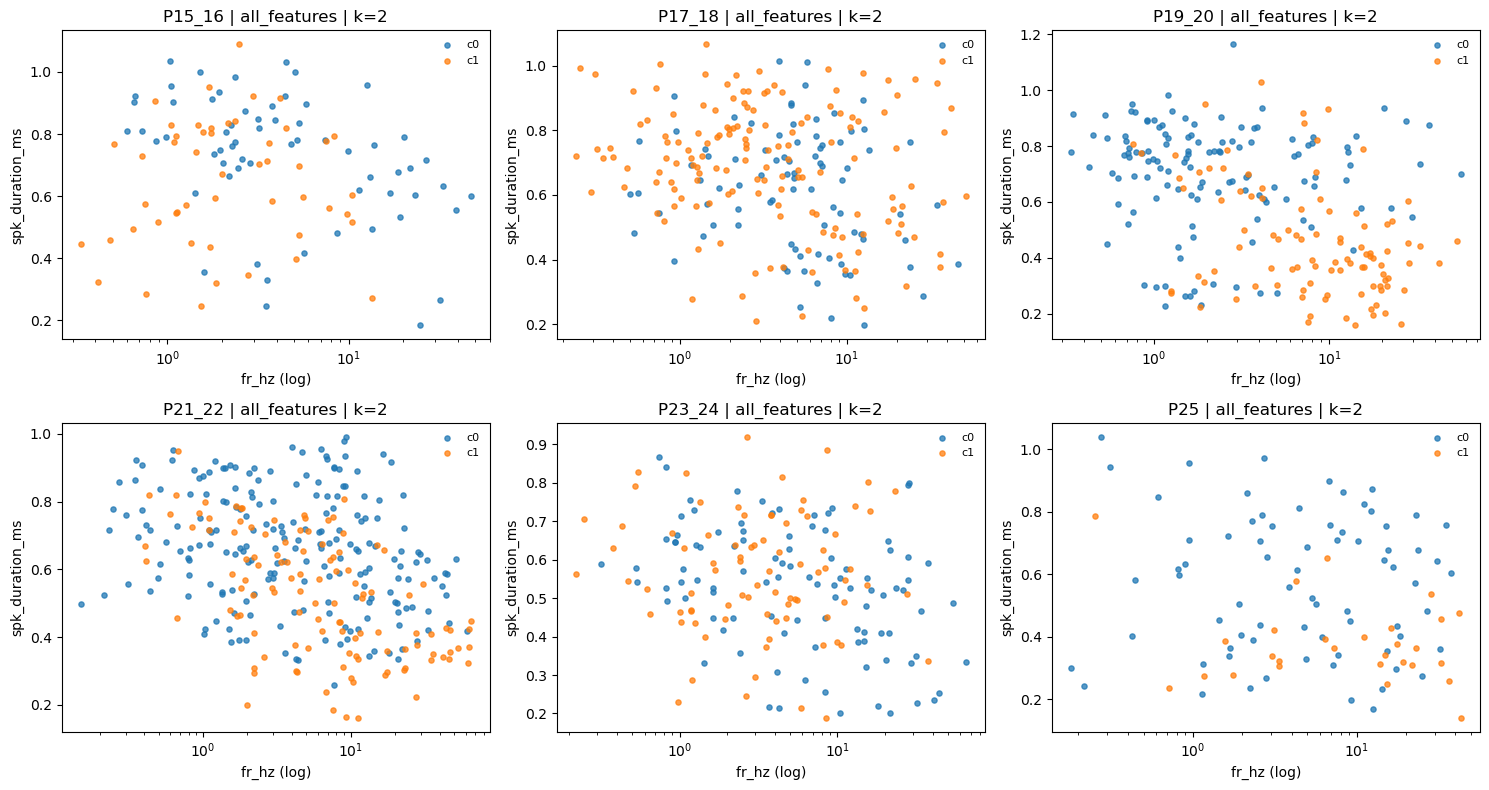

In [49]:
# For each age group, plot fr_hz vs spk_duration_ms using ALL features with k=2
from sklearn.mixture import GaussianMixture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

all_features = [
    "fr_hz",
    "burst_index",
    "cv2",
    "spk_duration_ms",
    "spk_peaktrough_ms",
    "spk_asymmetry",
    "refractory_ms_edge",
    "acg_peak_latency_ms",
]

exp = pd.read_csv("../results/feature_set_experiments/feature_set_k_experiments.csv")
dsel = exp[(exp["status"] == "ok") & (exp["feature_set"] == "all_features") & (exp["k"] == 2)].copy()
age_groups = sorted(dsel["age_group"].unique())

n = len(age_groups)
ncols = 3
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), squeeze=False)
axes = axes.ravel()

for i, age_group in enumerate(age_groups):
    ax = axes[i]
    df = pd.read_parquet(f"../results/{age_group}/{age_group}_clean_units.parquet").copy()

    # build matrix with same preprocessing
    used = []
    for c in all_features:
        if c == "fr_hz":
            df["log10_fr_hz"] = np.log10(df["fr_hz"].clip(lower=1e-6))
            used.append("log10_fr_hz")
        elif c in df.columns:
            used.append(c)

    X = df[used].to_numpy(dtype=float)
    mask = np.isfinite(X).all(axis=1) & np.isfinite(df["fr_hz"]) & np.isfinite(df["spk_duration_ms"])
    d = df.loc[mask].copy()
    X = X[mask]

    # standardize
    mu = X.mean(axis=0)
    sd = X.std(axis=0, ddof=0)
    sd[sd == 0] = 1.0
    Xz = (X - mu) / sd

    gmm = GaussianMixture(n_components=2, random_state=0, n_init=10, covariance_type="full")
    d["cluster"] = gmm.fit_predict(Xz)

    for cl in sorted(d["cluster"].unique()):
        s = d[d["cluster"] == cl]
        ax.scatter(s["fr_hz"], s["spk_duration_ms"], s=14, alpha=0.75, label=f"c{cl}")

    ax.set_xscale("log")
    ax.set_xlabel("fr_hz (log)")
    ax.set_ylabel("spk_duration_ms")
    ax.set_title(f"{age_group} | all_features | k=2")
    ax.legend(frameon=False, fontsize=8)

for j in range(len(age_groups), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


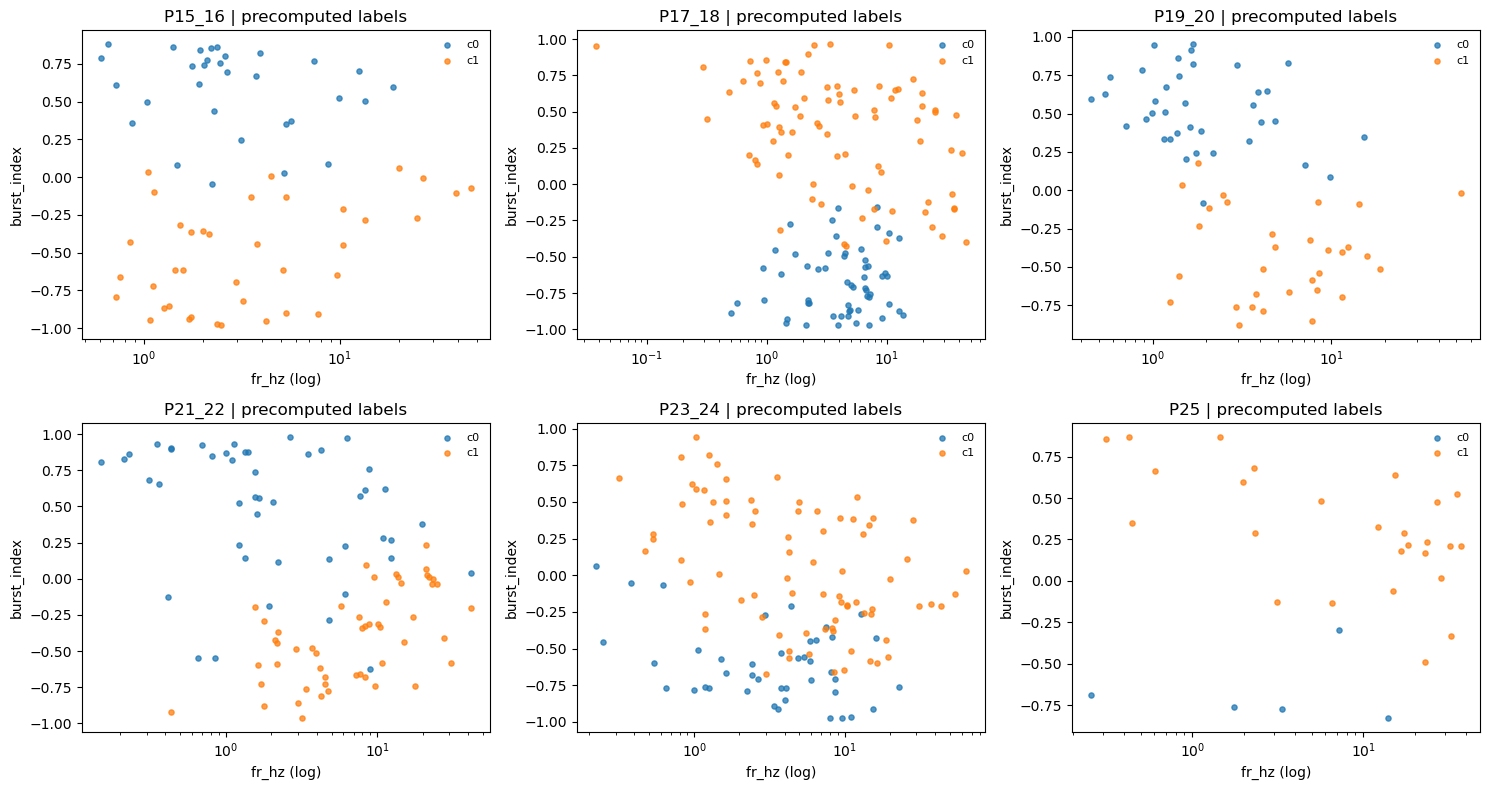

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Uses precomputed labels from compare_type_u (no retraining)
base = "../results/type_u_comparison"  # or ../results/type_u_comparison
age_groups = ["P15_16","P17_18","P19_20","P21_22","P23_24","P25"]

n = len(age_groups)
ncols = 3
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)
axes = axes.ravel()

for i, g in enumerate(age_groups):
    ax = axes[i]
    p = f"{base}/{g}/{g}_gmm2_vs_type_u.parquet"
    d = pd.read_parquet(p)

    for cl in sorted(d["gmm_cluster"].dropna().unique()):
        s = d[d["gmm_cluster"] == cl]
        ax.scatter(s["fr_hz"], s["burst_index"], s=14, alpha=0.75, label=f"c{int(cl)}")

    ax.set_xscale("log")
    ax.set_xlabel("fr_hz (log)")
    ax.set_ylabel("burst_index")
    ax.set_title(f"{g} | precomputed labels")
    ax.legend(frameon=False, fontsize=8)

for j in range(len(age_groups), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


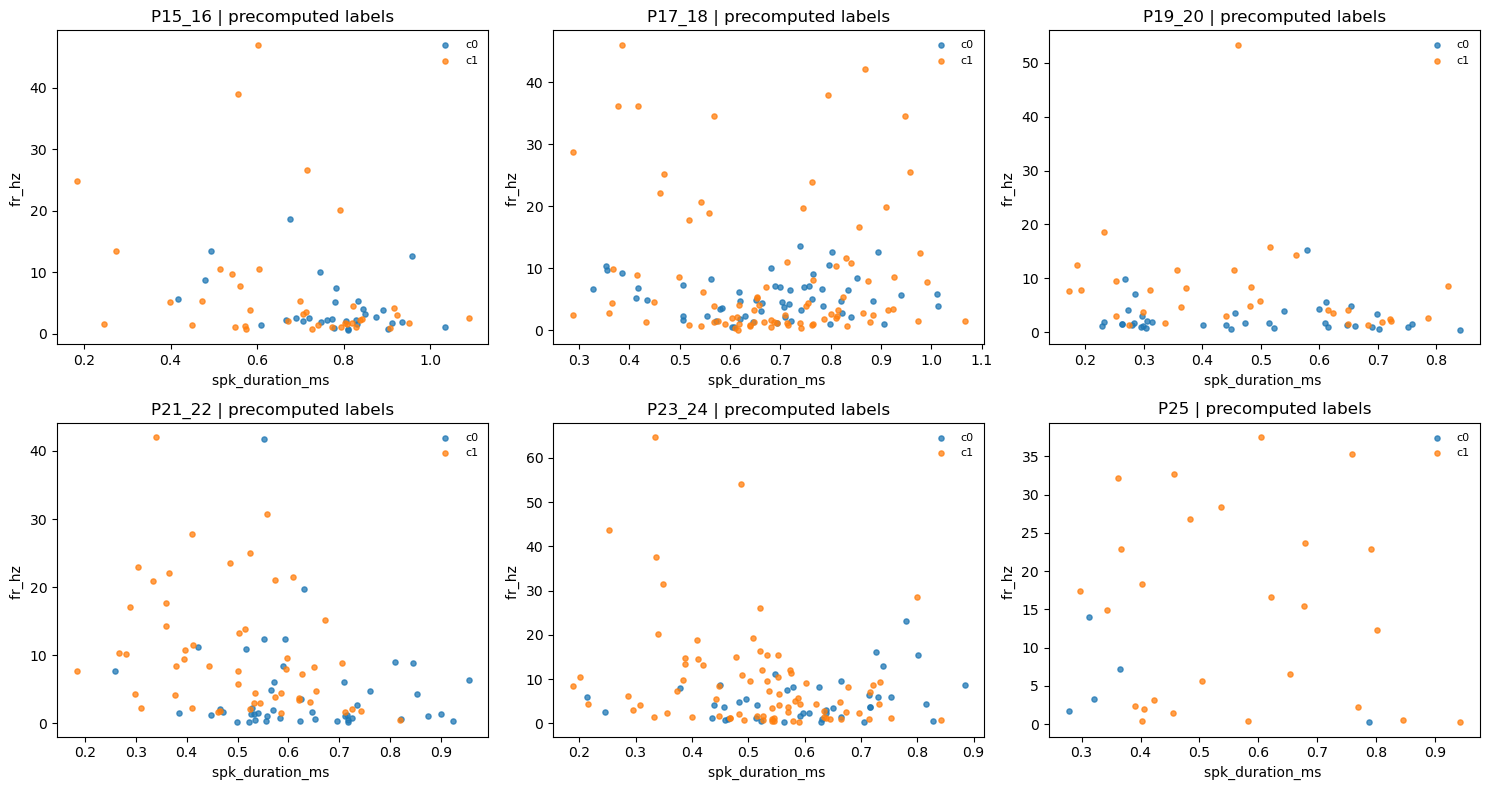

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Uses precomputed labels from compare_type_u (no retraining)
base = "../results/type_u_comparison"  # or ../results/type_u_comparison
age_groups = ["P15_16","P17_18","P19_20","P21_22","P23_24","P25"]

n = len(age_groups)
ncols = 3
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)
axes = axes.ravel()

for i, g in enumerate(age_groups):
    ax = axes[i]
    p = f"{base}/{g}/{g}_gmm2_vs_type_u.parquet"
    d = pd.read_parquet(p)

    for cl in sorted(d["gmm_cluster"].dropna().unique()):
        s = d[d["gmm_cluster"] == cl]
        ax.scatter(s["spk_duration_ms"], s["fr_hz"], s=14, alpha=0.75, label=f"c{int(cl)}")


    ax.set_xlabel("spk_duration_ms ")
    ax.set_ylabel("fr_hz ")
    ax.set_title(f"{g} | precomputed labels")
    ax.legend(frameon=False, fontsize=8)

for j in range(len(age_groups), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


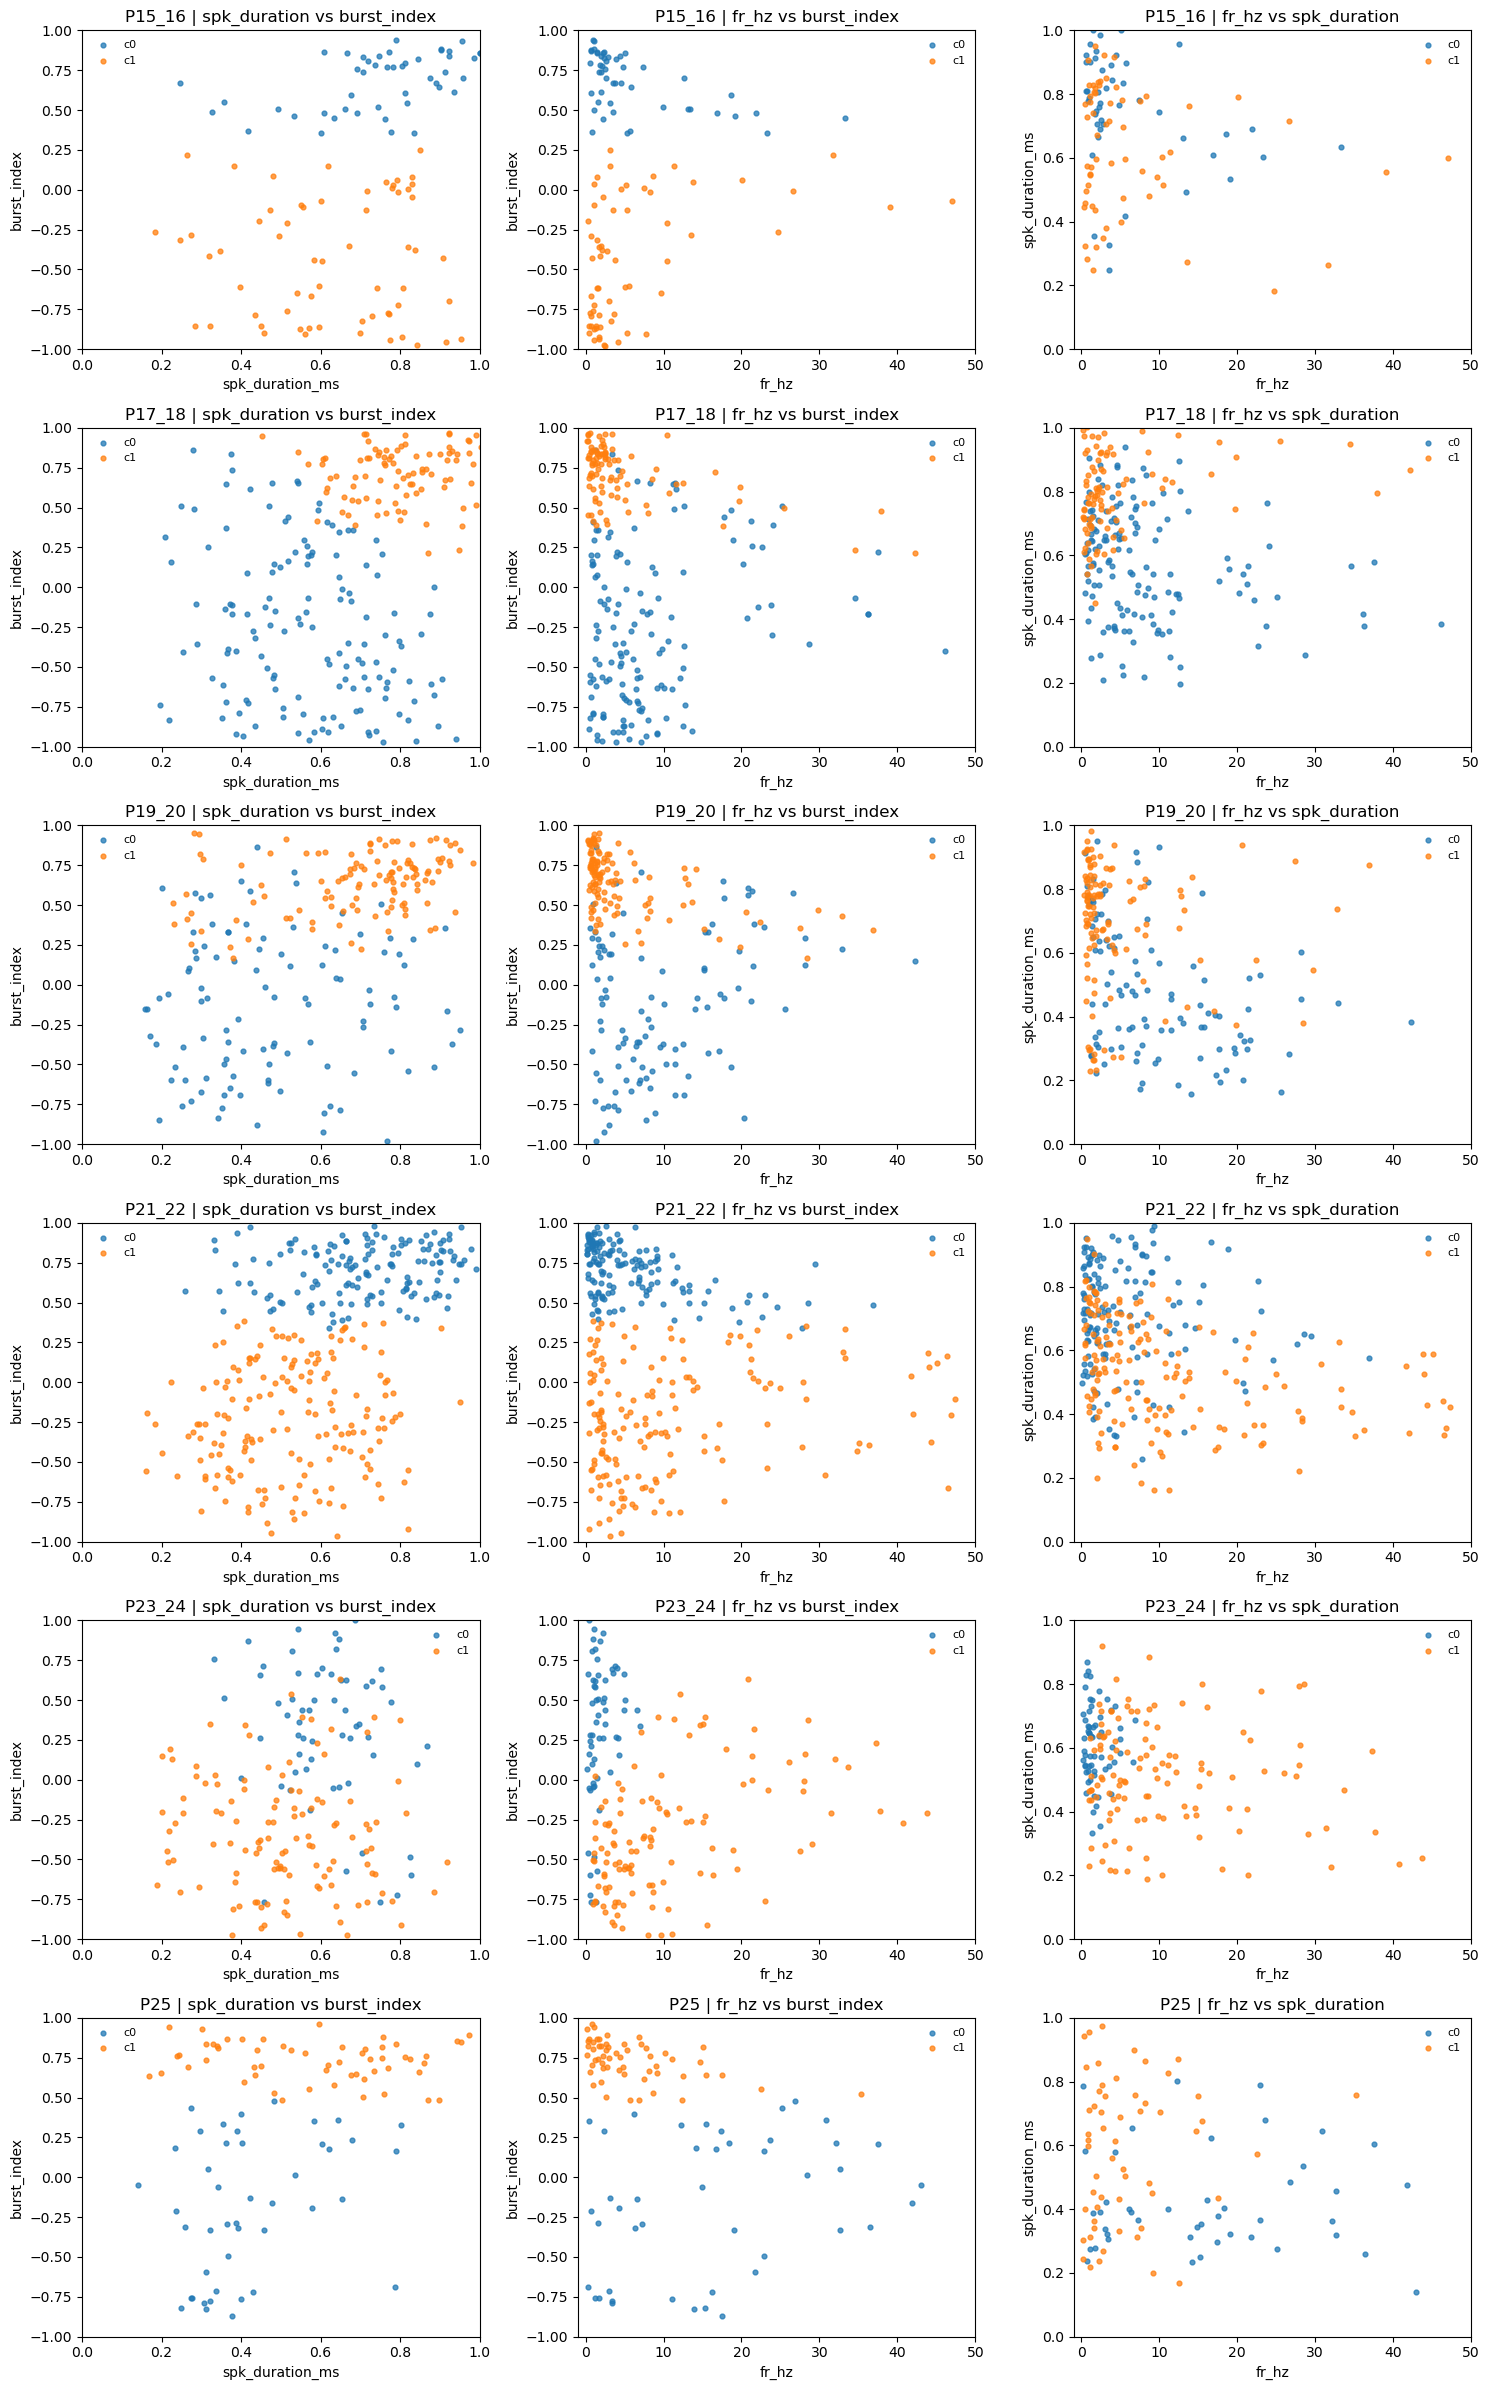

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Precomputed labels (no retraining)
base = "../results/type_u_comparison_smallfeat"  # change if needed
age_groups = ["P15_16", "P17_18", "P19_20", "P21_22", "P23_24", "P25"]

# Load all groups once
data = {g: pd.read_parquet(f"{base}/{g}/{g}_gmm2_vs_type_u.parquet") for g in age_groups}

# Global limits (except burst_index fixed to [-1, 1])
all_fr = pd.concat([data[g]["fr_hz"] for g in age_groups], ignore_index=True)
all_spk = pd.concat([data[g]["spk_duration_ms"] for g in age_groups], ignore_index=True)

fr_min, fr_max = all_fr.min(), all_fr.max()
fr_min = -1
fr_max = 50
spk_min, spk_max = all_spk.min(), all_spk.max()
spk_min = 0
spk_max = 1
burst_min, burst_max = -1, 1  # fixed by request

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 24), squeeze=False)

for r, g in enumerate(age_groups):
    d = data[g]

    # Col 1: spk_duration vs burst_index
    ax = axes[r, 0]
    for cl in sorted(d["gmm_cluster"].dropna().unique()):
        s = d[d["gmm_cluster"] == cl]
        ax.scatter(s["spk_duration_ms"], s["burst_index"], s=12, alpha=0.75, label=f"c{int(cl)}")
    ax.set_xlabel("spk_duration_ms")
    ax.set_ylabel("burst_index")
    ax.set_xlim(spk_min, spk_max)
    ax.set_ylim(burst_min, burst_max)
    ax.set_title(f"{g} | spk_duration vs burst_index")
    ax.legend(frameon=False, fontsize=8)

    # Col 2: fr_hz vs burst_index (NO LOG SCALE)
    ax = axes[r, 1]
    for cl in sorted(d["gmm_cluster"].dropna().unique()):
        s = d[d["gmm_cluster"] == cl]
        ax.scatter(s["fr_hz"], s["burst_index"], s=12, alpha=0.75, label=f"c{int(cl)}")
    ax.set_xlabel("fr_hz")
    ax.set_ylabel("burst_index")
    ax.set_xlim(fr_min, fr_max)
    ax.set_ylim(burst_min, burst_max)
    ax.set_title(f"{g} | fr_hz vs burst_index")
    ax.legend(frameon=False, fontsize=8)

    # Col 3: fr_hz vs spk_duration (NO LOG SCALE)
    ax = axes[r, 2]
    for cl in sorted(d["gmm_cluster"].dropna().unique()):
        s = d[d["gmm_cluster"] == cl]
        ax.scatter(s["fr_hz"], s["spk_duration_ms"], s=12, alpha=0.75, label=f"c{int(cl)}")
    ax.set_xlabel("fr_hz")
    ax.set_ylabel("spk_duration_ms")
    ax.set_xlim(fr_min, fr_max)
    ax.set_ylim(spk_min, spk_max)
    ax.set_title(f"{g} | fr_hz vs spk_duration")
    ax.legend(frameon=False, fontsize=8)

plt.tight_layout()
plt.show()


Features used in run_config.json:
  - fr_hz
  - spk_duration_ms
  - refractory_ms_edge


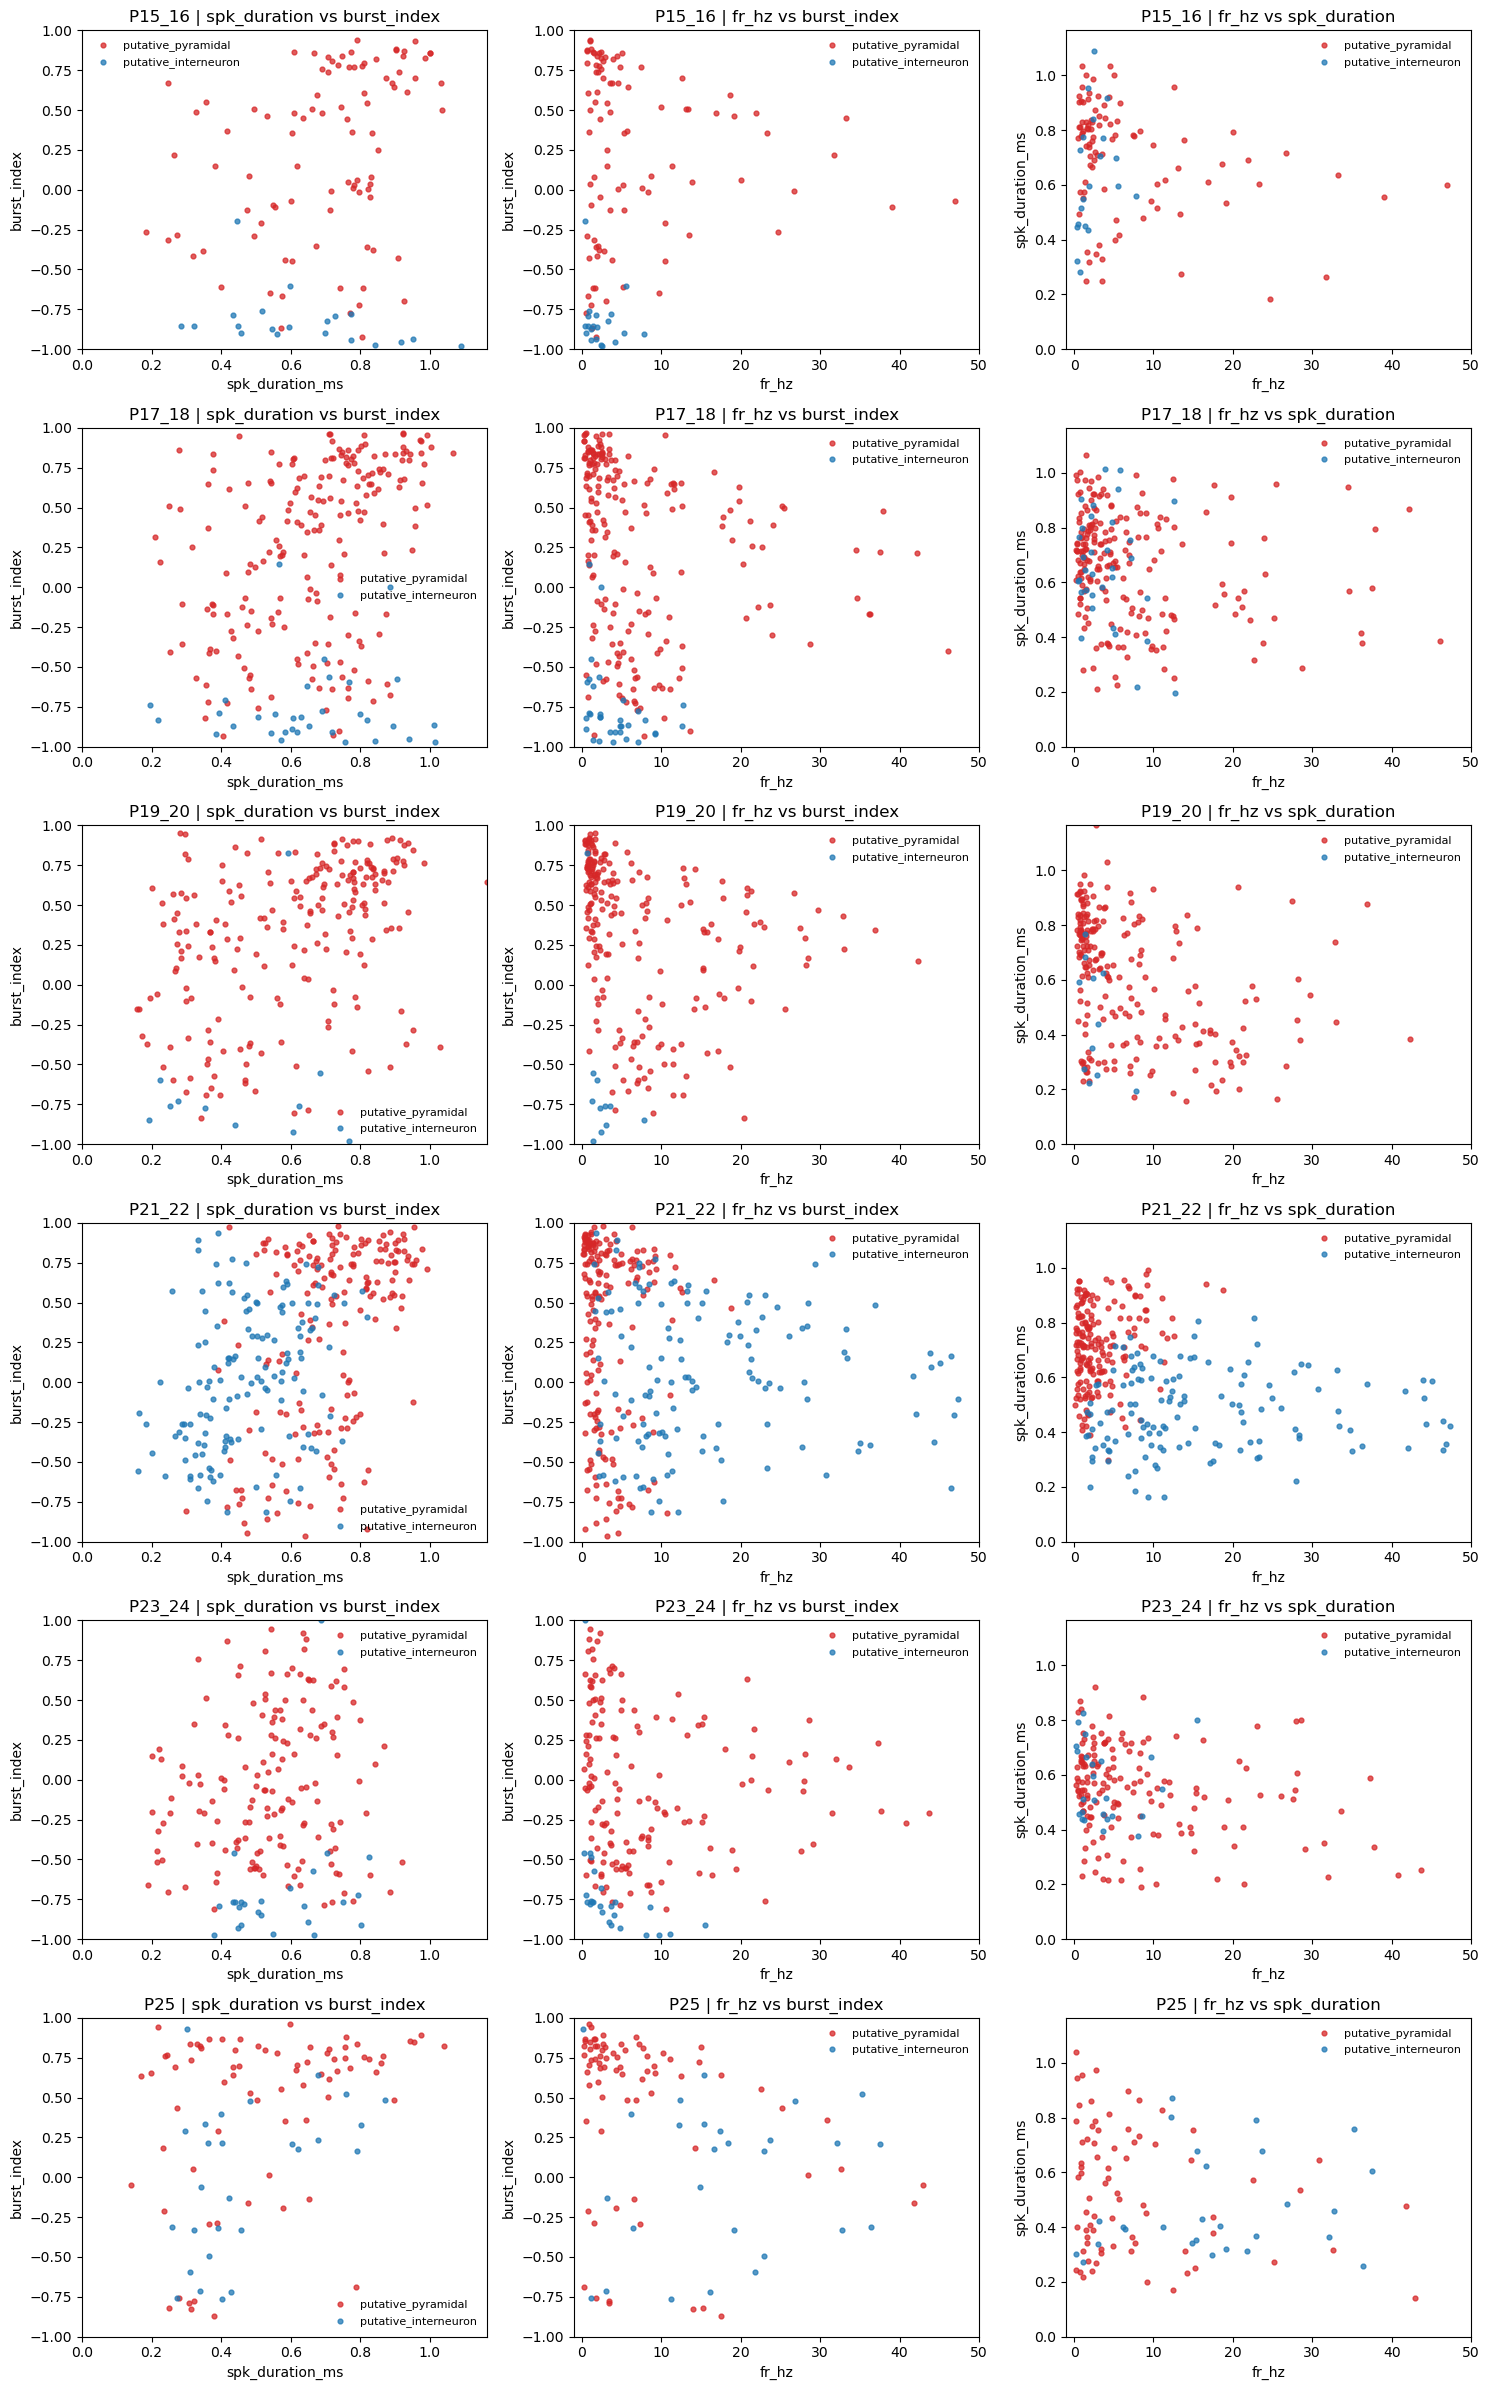

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
# Precomputed labels (no retraining)
base = "../results/type_u_comparison_few"  # change if needed
age_groups = ["P15_16", "P17_18", "P19_20", "P21_22", "P23_24", "P25"]
#print features from run_config.json

run_config_path = f"{base}/run_config.json"
with open(run_config_path, "r") as f:
    run_config = json.load(f)
print("Features used in run_config.json:")
for feature in run_config["features"]:
    print(f"  - {feature}")

# Load all groups
data = {g: pd.read_parquet(f"{base}/{g}/{g}_gmm2_vs_type_u.parquet").copy() for g in age_groups}

# Global limits
all_fr = pd.concat([data[g]["fr_hz"] for g in age_groups], ignore_index=True)
all_spk = pd.concat([data[g]["spk_duration_ms"] for g in age_groups], ignore_index=True)
fr_min, fr_max = all_fr.min(), all_fr.max()
fr_min = -1
fr_max = 50
spk_min, spk_max = all_spk.min(), all_spk.max()
spk_min = 0

burst_min, burst_max = -1, 1  # fixed

def zscore(s):
    s = pd.to_numeric(s, errors="coerce")
    sd = s.std(ddof=0)
    if sd == 0 or np.isnan(sd):
        return pd.Series(np.zeros(len(s)), index=s.index)
    return (s - s.mean()) / sd

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 24), squeeze=False)

for r, g in enumerate(age_groups):
    #print number of neurons per group
    

    d = data[g].copy()

    # Build a heuristic "interneuron-ness" score per neuron:
    # higher FR + higher burst + lower duration => more interneuron-like
    d["fr_z"] = zscore(d["fr_hz"])
    d["burst_z"] = zscore(d["burst_index"])
    d["dur_z"] = zscore(d["spk_duration_ms"])
    d["int_score"] = d["fr_z"] - d["burst_z"] - d["dur_z"]
    d["int_score"] = d["fr_z"] - d["dur_z"]

    # Map cluster -> putative type by average score
    cl_score = d.groupby("gmm_cluster")["int_score"].mean()
    int_cluster = cl_score.idxmax()
    pyr_cluster = [c for c in cl_score.index if c != int_cluster][0]

    d["putative_type"] = np.where(d["gmm_cluster"] == int_cluster, "putative_interneuron", "putative_pyramidal")

    palette = {
        "putative_pyramidal": "#d62728",  # red
        "putative_interneuron": "#1f77b4",    # blue
    }

    # Col 1: spk_duration vs burst_index
    ax = axes[r, 0]
    for t in ["putative_pyramidal", "putative_interneuron"]:
        s = d[d["putative_type"] == t]
        ax.scatter(s["spk_duration_ms"], s["burst_index"], s=12, alpha=0.75, label=t, color=palette[t])
    ax.set_xlabel("spk_duration_ms")
    ax.set_ylabel("burst_index")
    ax.set_xlim(spk_min, spk_max)
    ax.set_ylim(burst_min, burst_max)
    ax.set_title(f"{g} | spk_duration vs burst_index")
    ax.legend(frameon=False, fontsize=8)

    # Col 2: fr_hz vs burst_index
    ax = axes[r, 1]
    for t in ["putative_pyramidal", "putative_interneuron"]:
        s = d[d["putative_type"] == t]
        ax.scatter(s["fr_hz"], s["burst_index"], s=12, alpha=0.75, label=t, color=palette[t])
    ax.set_xlabel("fr_hz")
    ax.set_ylabel("burst_index")
    ax.set_xlim(fr_min, fr_max)
    ax.set_ylim(burst_min, burst_max)
    ax.set_title(f"{g} | fr_hz vs burst_index")
    ax.legend(frameon=False, fontsize=8)

    # Col 3: fr_hz vs spk_duration
    ax = axes[r, 2]
    for t in ["putative_pyramidal", "putative_interneuron"]:
        s = d[d["putative_type"] == t]
        ax.scatter(s["fr_hz"], s["spk_duration_ms"], s=12, alpha=0.75, label=t, color=palette[t])
    ax.set_xlabel("fr_hz")
    ax.set_ylabel("spk_duration_ms")
    ax.set_xlim(fr_min, fr_max)
    ax.set_ylim(spk_min, spk_max)
    ax.set_title(f"{g} | fr_hz vs spk_duration")
    ax.legend(frameon=False, fontsize=8)

plt.tight_layout()
plt.show()
#print total number of neurons per group
print 

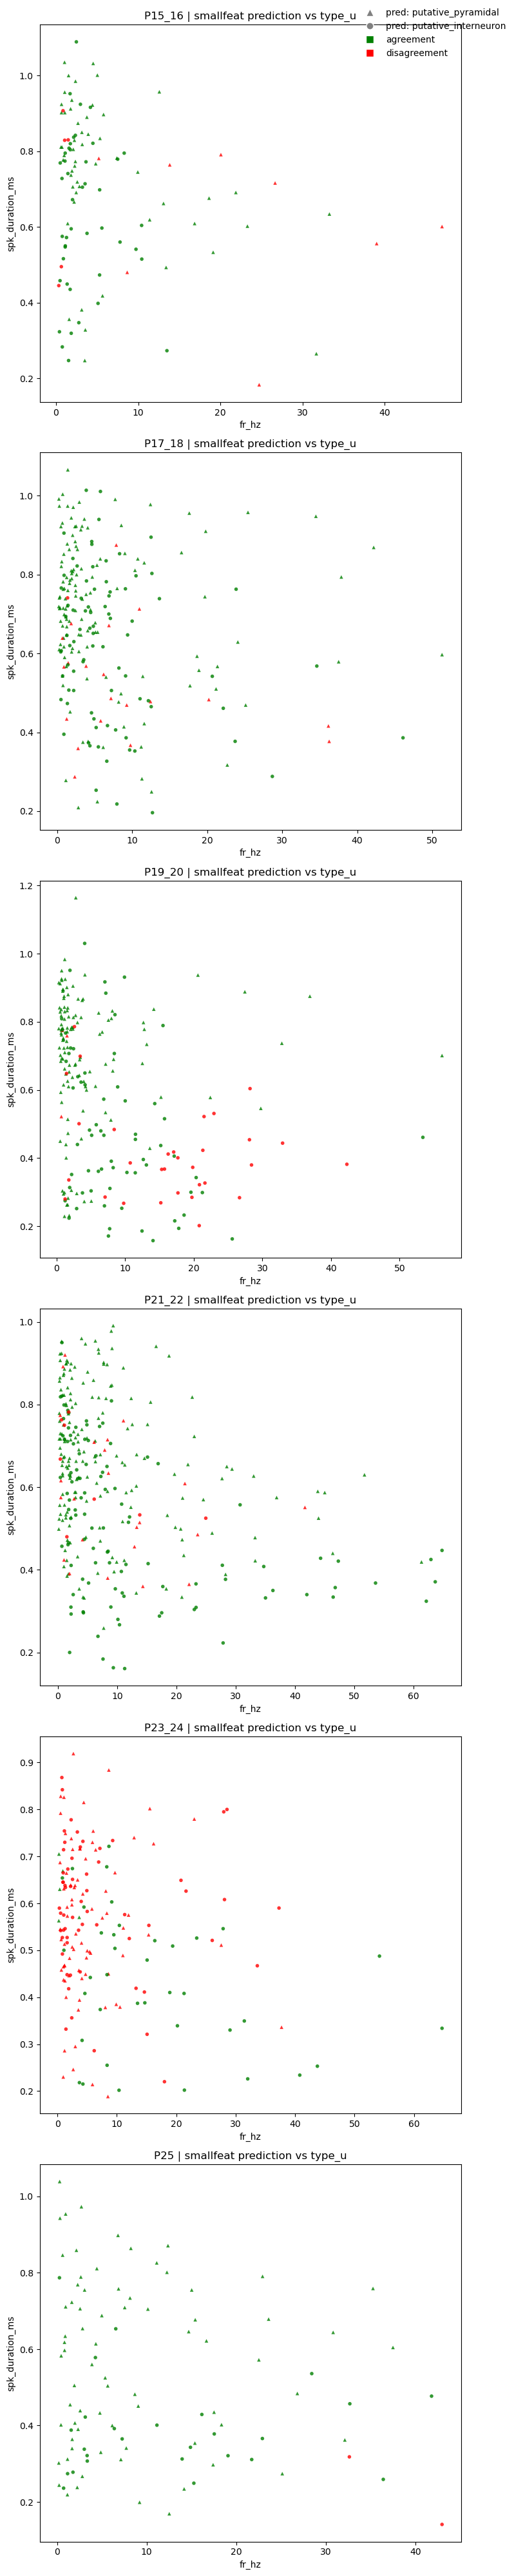

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

base = "../results/type_u_comparison"
age_groups = ["P15_16", "P17_18", "P19_20", "P21_22", "P23_24", "P25"]

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(8, 40), squeeze=False)

# color = agreement, marker = predicted type
color_map = {True: "green", False: "red"}
marker_map = {"putative_pyramidal": "^", "putative_interneuron": "o"}

for r, g in enumerate(age_groups):
    ax = axes[r, 0]
    d = pd.read_parquet(f"{base}/{g}/{g}_gmm2_vs_type_u.parquet").copy()

    if "type_u_binary" not in d.columns:
        d["type_u_binary"] = pd.to_numeric(d["allcel__type_u"], errors="coerce").astype("Int64")
    if "pred_binary" not in d.columns:
        raise ValueError(f"{g}: pred_binary not found")

    d = d[d["type_u_binary"].notna()].copy()
    d["pred_type"] = np.where(d["pred_binary"] == 0, "putative_interneuron", "putative_pyramidal")
    d["agree"] = d["pred_binary"].astype("Int64") == d["type_u_binary"].astype("Int64")

    for pred_type in ["putative_pyramidal", "putative_interneuron"]:
        for agree_flag in [True, False]:
            s = d[(d["pred_type"] == pred_type) & (d["agree"] == agree_flag)]
            ax.scatter(
                s["fr_hz"],
                s["spk_duration_ms"],
                s=16,
                alpha=0.8,
                c=color_map[agree_flag],
                marker=marker_map[pred_type],
                edgecolors="none"
            )

    ax.set_xlabel("fr_hz")
    ax.set_ylabel("spk_duration_ms")
    ax.set_title(f"{g} | smallfeat prediction vs type_u")

# global legend (same for all axes)
legend_elems = [
    Line2D([0], [0], marker="^", color="w", markerfacecolor="gray", markersize=8, label="pred: putative_pyramidal"),
    Line2D([0], [0], marker="o", color="w", markerfacecolor="gray", markersize=8, label="pred: putative_interneuron"),
    Line2D([0], [0], marker="s", color="w", markerfacecolor="green", markersize=8, label="agreement"),
    Line2D([0], [0], marker="s", color="w", markerfacecolor="red", markersize=8, label="disagreement"),
]
fig.legend(handles=legend_elems, loc="upper right", frameon=False)

plt.tight_layout(rect=[0, 0, 0.92, 1])  # keep space for legend
plt.show()




Features used in run_config.json:
  - fr_hz
  - burst_index
  - cv2
  - spk_duration_ms
  - spk_peaktrough_ms
  - spk_asymmetry
  - refractory_ms_edge
  - acg_peak_latency_ms


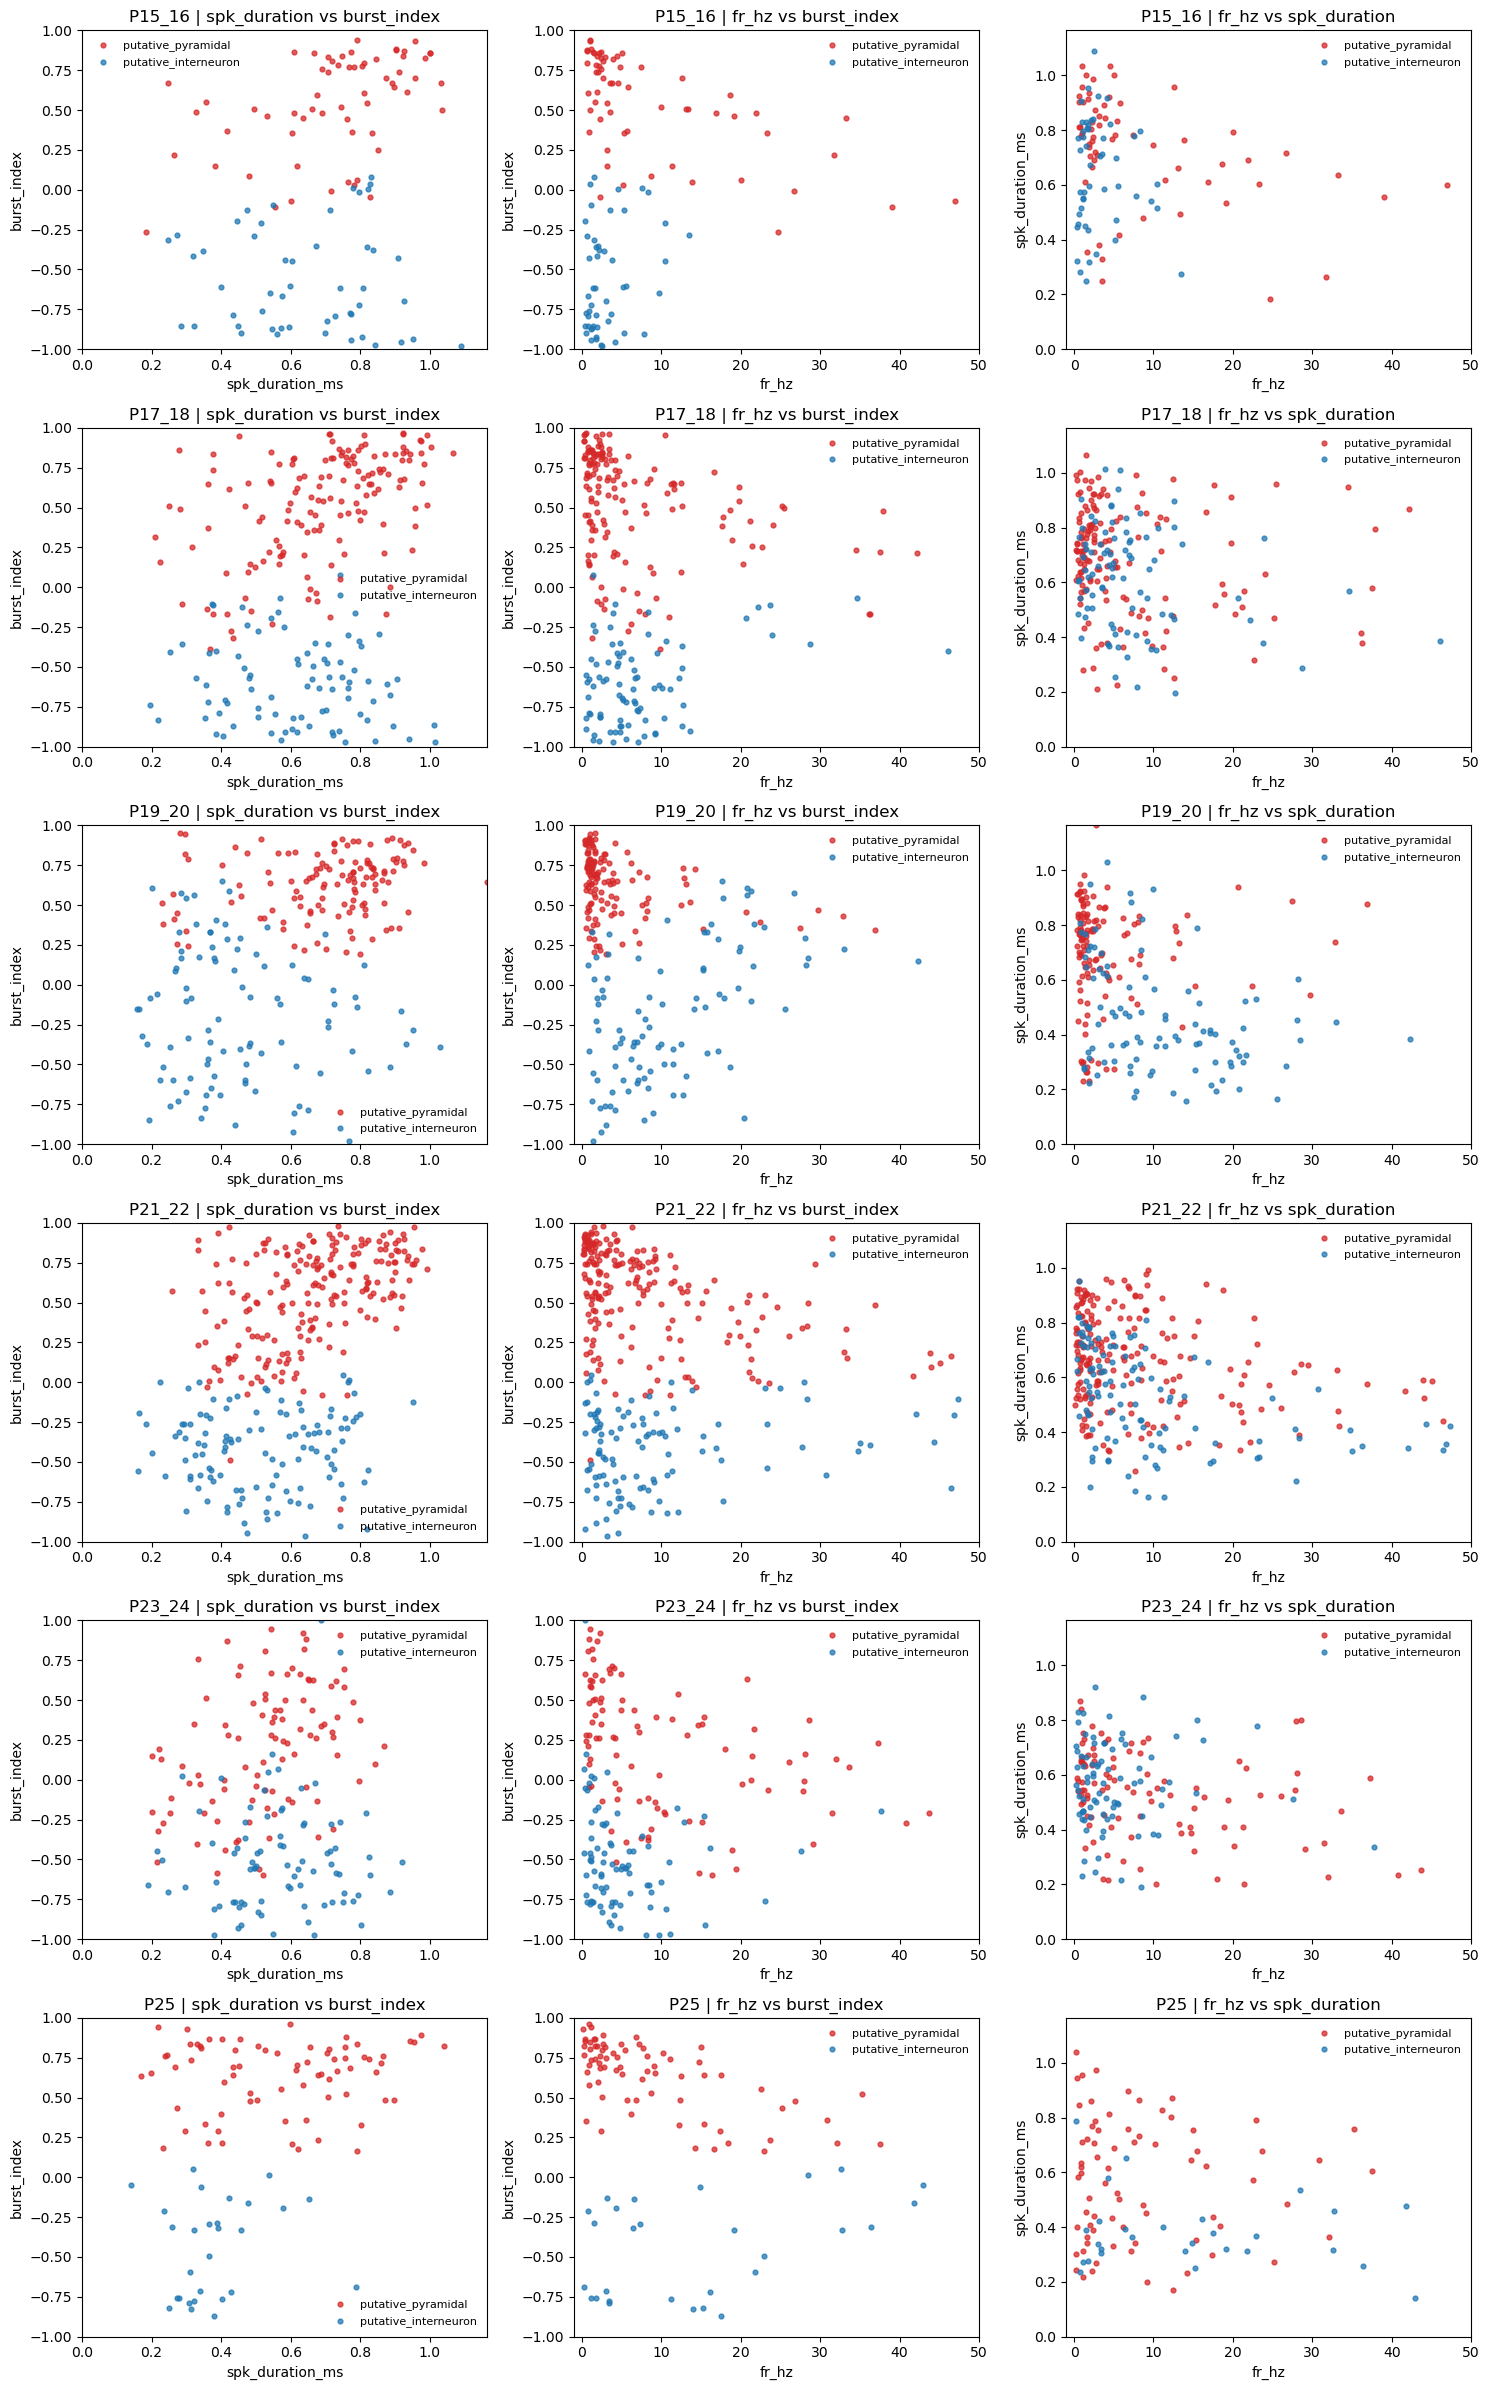

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
# Precomputed labels (no retraining)
base = "../results/type_u_comparison"  # change if needed
age_groups = ["P15_16", "P17_18", "P19_20", "P21_22", "P23_24", "P25"]
#print features from run_config.json

run_config_path = f"{base}/run_config.json"
with open(run_config_path, "r") as f:
    run_config = json.load(f)
print("Features used in run_config.json:")
for feature in run_config["features"]:
    print(f"  - {feature}")

# Load all groups
data = {g: pd.read_parquet(f"{base}/{g}/{g}_gmm2_vs_type_u.parquet").copy() for g in age_groups}

# Global limits
all_fr = pd.concat([data[g]["fr_hz"] for g in age_groups], ignore_index=True)
all_spk = pd.concat([data[g]["spk_duration_ms"] for g in age_groups], ignore_index=True)
fr_min, fr_max = all_fr.min(), all_fr.max()
fr_min = -1
fr_max = 50
spk_min, spk_max = all_spk.min(), all_spk.max()
spk_min = 0

burst_min, burst_max = -1, 1  # fixed

def zscore(s):
    s = pd.to_numeric(s, errors="coerce")
    sd = s.std(ddof=0)
    if sd == 0 or np.isnan(sd):
        return pd.Series(np.zeros(len(s)), index=s.index)
    return (s - s.mean()) / sd

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 24), squeeze=False)

for r, g in enumerate(age_groups):
    #print number of neurons per group
    

    d = data[g].copy()

    # Build a heuristic "interneuron-ness" score per neuron:
    # higher FR + higher burst + lower duration => more interneuron-like
    d["fr_z"] = zscore(d["fr_hz"])
    d["burst_z"] = zscore(d["burst_index"])
    d["dur_z"] = zscore(d["spk_duration_ms"])
    d["int_score"] = d["fr_z"] - d["burst_z"] - d["dur_z"]

    # Map cluster -> putative type by average score
    cl_score = d.groupby("gmm_cluster")["int_score"].mean()
    int_cluster = cl_score.idxmax()
    pyr_cluster = [c for c in cl_score.index if c != int_cluster][0]

    d["putative_type"] = np.where(d["gmm_cluster"] == int_cluster, "putative_interneuron", "putative_pyramidal")

    palette = {
        "putative_pyramidal": "#d62728",  # red
        "putative_interneuron": "#1f77b4",    # blue
    }

    # Col 1: spk_duration vs burst_index
    ax = axes[r, 0]
    for t in ["putative_pyramidal", "putative_interneuron"]:
        s = d[d["putative_type"] == t]
        ax.scatter(s["spk_duration_ms"], s["burst_index"], s=12, alpha=0.75, label=t, color=palette[t])
    ax.set_xlabel("spk_duration_ms")
    ax.set_ylabel("burst_index")
    ax.set_xlim(spk_min, spk_max)
    ax.set_ylim(burst_min, burst_max)
    ax.set_title(f"{g} | spk_duration vs burst_index")
    ax.legend(frameon=False, fontsize=8)

    # Col 2: fr_hz vs burst_index
    ax = axes[r, 1]
    for t in ["putative_pyramidal", "putative_interneuron"]:
        s = d[d["putative_type"] == t]
        ax.scatter(s["fr_hz"], s["burst_index"], s=12, alpha=0.75, label=t, color=palette[t])
    ax.set_xlabel("fr_hz")
    ax.set_ylabel("burst_index")
    ax.set_xlim(fr_min, fr_max)
    ax.set_ylim(burst_min, burst_max)
    ax.set_title(f"{g} | fr_hz vs burst_index")
    ax.legend(frameon=False, fontsize=8)

    # Col 3: fr_hz vs spk_duration
    ax = axes[r, 2]
    for t in ["putative_pyramidal", "putative_interneuron"]:
        s = d[d["putative_type"] == t]
        ax.scatter(s["fr_hz"], s["spk_duration_ms"], s=12, alpha=0.75, label=t, color=palette[t])
    ax.set_xlabel("fr_hz")
    ax.set_ylabel("spk_duration_ms")
    ax.set_xlim(fr_min, fr_max)
    ax.set_ylim(spk_min, spk_max)
    ax.set_title(f"{g} | fr_hz vs spk_duration")
    ax.legend(frameon=False, fontsize=8)

plt.tight_layout()
plt.show()
#print total number of neurons per group
print 